In [1]:
from scipy.stats import pearsonr
import pandas as pd
import random 
from scipy.stats import describe, pearsonr, zscore, f_oneway, yeojohnson, shapiro, probplot, levene
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

def explore(df: pd.DataFrame) -> pd.DataFrame:
    ex1, ex2, ex3 = random.sample(range(len(df)), 3)

    print("Dataframe total rows: ", len(df))
    df_info = pd.DataFrame(data = df.dtypes)
    not_missing_values_total = df.notnull().sum()
    not_missing_values_percent = round(not_missing_values_total/len(df)*100,2).astype(str)+" %"

    return pd.concat([df_info[0].rename("Data Type"),\
            df.T[ex1].rename("Example 1"),\
            df.T[ex2].rename("Example 2"),\
            df.T[ex3].rename("Example 3"),\
            not_missing_values_total.rename("Total Not Missing"), \
            not_missing_values_percent.rename("% of not missing values")], axis=1)
    
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded, dtype='float64')
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included    

def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pvalues

In [20]:
import saspy
sas_session = saspy.SASsession()
sas_session

Using SAS Config named: oda
SAS Connection established. Subprocess id is 1165



Access Method         = IOM
SAS Config name       = oda
SAS Config file       = /home/armando/.virtualenvs/school-54vk9BCB/lib/python3.8/site-packages/saspy/sascfg_personal.py
WORK Path             = /saswork/SAS_work46F30001F904_odaws02-usw2.oda.sas.com/SAS_workBACB0001F904_odaws02-usw2.oda.sas.com/
SAS Version           = 9.04.01M6P11072018
SASPy Version         = 4.4.0
Teach me SAS          = False
Batch                 = False
Results               = Pandas
SAS Session Encoding  = utf-8
Python Encoding value = utf-8
SAS process Pid value = 129284


In [24]:
%%SAS sas_session

libname cortex '~/my_shared_file_links/u39842936/Cortex Data Sets';

In [4]:
import pandas as pd

# data1 = sas_session.sasdata2dataframe(
# table='hist',
# libref='cortex'
# )

# data2 = sas_session.sasdata2dataframe(
# table='target_rd2',
# libref='cortex'
# )

## Merge the Data

In [5]:
# data_merge = pd.merge(data1, data2, on=["ID"],how="right")
# data_merge.to_csv("og3.csv", index= False)
data_merge = pd.read_csv("og3.csv")
len(data_merge)

1000000

## Treating Missing Values

Please be aware that deleting all missing values can induce a selection bias. 
Some missing values are very informative. For example, when MinGift is missing, it means that the donor never gave in the past 10 years (leading to but excluding last year). Instead of deleting this information, replacing it by 0 is more appropriate!

A good understanding of the business case and the data can help you come up with more appropriate strategies to deal with missing values.

In [6]:
# In this case, we are replacing MinGift by 0.
# You can do the same for what you think is reasonable for dealing with the other variables.
var_types = {"number" : "median", "object" : "mode"}
for var_type in list(var_types.keys()):
    for col in data_merge.select_dtypes(include=var_type).columns:
        data_merge[col] = data_merge[col].fillna(getattr(data_merge[col], var_types[var_type])())
            
for col in data_merge.select_dtypes(include="object"):
    data_merge[col] = data_merge[col].astype('category')
    data_merge[col] = data_merge[col].cat.codes
    
data_merge.sample(2)

,ID,LastName,FirstName,Woman,Age,Salary,Education,City,SeniorList,NbActivities,...,Frequency,Seniority,TotalGift,MinGift,MaxGift,GaveLastYear,AmtLastYear,Contact,GaveThisYear,AmtThisYear
150344,2150345.0,53589,2535,1.0,82.0,21300.0,1,3,10.0,0.0,...,1.0,4.0,40.0,20.0,30.0,0.0,0.0,1.0,0.0,0.0
413561,2413562.0,100995,2146,0.0,24.0,2700.0,2,3,8.0,1.0,...,1.0,3.0,10.0,10.0,10.0,0.0,0.0,0.0,0.0,0.0


In [7]:
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.feature_selection import SelectFromModel
# sel = SelectFromModel(RandomForestRegressor())
# X = data_merge.drop(["ID", "AmtThisYear", "GaveThisYear", "LastName", "FirstName"], axis=1)
# sel.fit(X, data_merge["GaveThisYear"])

# importances = sel.estimator_.feature_importances_
# names = sel.estimator_.feature_names_in_

# indices = np.argsort(importances)[::-1]

# plt.figure(figsize=(10,5))
# plt.title("Feature importances")
# plt.bar(range(X.shape[1]), importances[indices], color="r", align="center")
# plt.xticks(range(X.shape[1]), [names[i] for i in indices])
# plt.xlim([-1, X.shape[1]])
# plt.show()

In [8]:
from sklearn.preprocessing import PowerTransformer

power = PowerTransformer(method='yeo-johnson', standardize=True)
X= data_merge.drop(["ID", "GaveThisYear"], axis=1)
X_cols = X.columns
X = power.fit_transform(X)
X = pd.DataFrame(X, columns = X_cols) 

In [9]:
selection = ['Salary', 'Age', 'Contact', 'SeniorList',  'City', 'Education', 'Woman', 'TotalGift', 'AmtLastYear', 'NbActivities',]

cols = selection + ['GaveThisYear'] #['Age', 'Salary','MinGift', 'AmtLastYear','Woman', 'NbActivities', 'AmtThisYear']

In [10]:
data = X
data["GaveThisYear"] = data_merge["GaveThisYear"]


data = data[cols] 
data = data[(np.abs(zscore(data.select_dtypes(include ='number'))) < 2).all(axis=1)]
len(data)

861470

## Data Partition

In [11]:
# The code below is an illustration on how to sample data on train and validation samples.
# You could use another library or a built-in function to perform sampling.

from sklearn.model_selection import train_test_split
train, validation = train_test_split(data, test_size=0.4, random_state=12345, stratify = data.GaveThisYear) 

#train.head()
train.sample(2)

,Salary,Age,Contact,SeniorList,City,Education,Woman,TotalGift,AmtLastYear,NbActivities,GaveThisYear
871259,-0.668949,-0.017549,-0.333333,-0.333340,0.503416,-1.310843,0.966683,0.003631,-0.372938,1.253741,0.0
869164,0.703464,1.363931,-0.333333,-1.552988,1.149933,-1.310843,0.966683,0.003631,-0.372938,-0.709013,1.0


In [12]:
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, precision_recall_curve,
                             roc_auc_score, roc_curve)
from sklearn.model_selection import (GridSearchCV, KFold, cross_validate,)
from sklearn import decomposition
from sklearn.pipeline import Pipeline

# Prebuilt Models

The sk-learn library offers more advanced models. 

sk-learn library: https://scikit-learn.org/stable/index.html  

## Logistic Regression Model

In [13]:
from sklearn.linear_model import LogisticRegression

#comment: it's numpy array ==> categorical variables
X_train = train.drop("GaveThisYear", axis=1)
Y_train = train['GaveThisYear']
X_valid = validation.drop("GaveThisYear", axis=1)
Y_valid = validation['GaveThisYear']


regr = LogisticRegression()
regr.fit(X_train,Y_train)
regr_predict=regr.predict(X_valid)

In [14]:
#you can change the criteria

import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(Y_valid, regr_predict)
print(confusion_matrix)

[[303083      1]
 [ 41504      0]]


In [15]:
from sklearn.metrics import classification_report
print(classification_report(Y_valid, regr_predict))

              precision    recall  f1-score   support

         0.0       0.88      1.00      0.94    303084
         1.0       0.00      0.00      0.00     41504

    accuracy                           0.88    344588
   macro avg       0.44      0.50      0.47    344588
weighted avg       0.77      0.88      0.82    344588



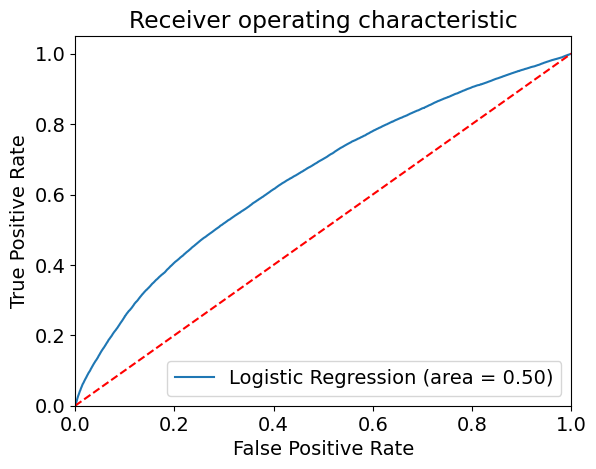

In [16]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt 
plt.rc("font", size=14)

logit_roc_auc = roc_auc_score(Y_valid, regr.predict(X_valid))
fpr, tpr, thresholds = roc_curve(Y_valid, regr.predict_proba(X_valid)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [17]:
class LogisticRegressionWithThreshold(LogisticRegression):
    def predict(self, X, threshold=None):
        if threshold == None: # If no threshold passed in, simply call the base class predict, effectively threshold=0.5
            return LogisticRegression.predict(self, X)
        else:
            y_scores = LogisticRegression.predict_proba(self, X)[:, 1]
            y_pred_with_threshold = (y_scores >= threshold).astype(int)

            return y_pred_with_threshold
    
    def threshold_from_optimal_accuracy(self, X, y):
            y_scores = LogisticRegression.predict_proba(self, X)[:, 1]
            precisions, recalls, thresholds = precision_recall_curve(y, y_scores)
            
            accuracies = []
            tns = []
            fps = []
            fns = []
            tps = []

            for threshold in thresholds:
                y_pred_with_threshold = (y_scores >= threshold).astype(int)
                tn, fp, fn, tp = confusion_matrix(y, y_pred_with_threshold).ravel()

                accuracies.append((tp+tn)/(tn+fp+fn+tp))
                tns.append(tn), fps.append(fp), fns.append(fn), tps.append(tp)
            
            df_accuracy = pd.DataFrame({'threshold':thresholds, 'accuracy':accuracies, 'tn':tns, 'fp':fps, 'fn':fns, 'tp':tps})

            max_accuracy = df_accuracy['accuracy'].max()
            threshold = df_accuracy[df_accuracy['accuracy']==max_accuracy].iloc[0]['threshold']

            return threshold, max_accuracy, df_accuracy

pca = decomposition.PCA()
logreg = LogisticRegression()

pipe = Pipeline(steps=[('pca', pca), ('logistic_Reg', logreg)])
n_components = list(range(1,X.shape[1]+1,1))
C = np.logspace(-3, 3, 50)
penalty = ['l1', 'l2']
solver = ['lbfgs', 'liblinear','newton-cg']

parameters = dict(pca__n_components=n_components,
                  logistic_Reg__C=C,
                  logistic_Reg__penalty=penalty,
                  logistic_Reg__solver=solver
                  )

kfold = KFold(n_splits=10, random_state=10, shuffle=True) 
logreg = GridSearchCV(pipe, parameters, cv=kfold)
logreg = LogisticRegressionWithThreshold()
logreg.fit(X_train, Y_train)

#threshold, max_accuracy, df_accuracy = logreg.threshold_from_optimal_accuracy(X_train, Y_train)

print("\n Train")
y_predicted=logreg.predict(X_train)#, threshold)
print("score: ", logreg.score(X_train, Y_train))
print(classification_report(Y_train,y_predicted))

print("\n Test")
y_predicted=logreg.predict(X_valid)#, threshold)
print("score : ",logreg.score(X_valid,Y_valid))
print(classification_report(Y_valid,y_predicted))


 Train
score:  0.879554714615715


/home/armando/.virtualenvs/school-54vk9BCB/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/armando/.virtualenvs/school-54vk9BCB/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/armando/.virtualenvs/school-54vk9BCB/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

              precision    recall  f1-score   support

         0.0       0.88      1.00      0.94    454626
         1.0       0.00      0.00      0.00     62256

    accuracy                           0.88    516882
   macro avg       0.44      0.50      0.47    516882
weighted avg       0.77      0.88      0.82    516882


 Test
score :  0.8795518125993941
              precision    recall  f1-score   support

         0.0       0.88      1.00      0.94    303084
         1.0       0.00      0.00      0.00     41504

    accuracy                           0.88    344588
   macro avg       0.44      0.50      0.47    344588
weighted avg       0.77      0.88      0.82    344588



## Decision Tree Model

In [18]:
from sklearn.tree import DecisionTreeClassifier

X_train = train.drop("GaveThisYear", axis=1)
Y_train = train['GaveThisYear']
X_valid = validation.drop("GaveThisYear", axis=1)
Y_valid = validation['GaveThisYear']

DT_model = DecisionTreeClassifier(max_depth=5,criterion="entropy").fit(X_train,Y_train)
DT_predict_proba = DT_model.predict_proba(X_valid) #Predictions on Testing data
DT_predict = DT_model.predict(X_valid) #Predictions on Testing data
# Probabilities for each class
DT_probs = DT_model.predict_proba(X_valid)[:, 1]
print(DT_probs)

[0.06189386 0.09748879 0.06189386 ... 0.11998387 0.06189386 0.06189386]


In [19]:
pca = decomposition.PCA()
dt_model = DecisionTreeClassifier()
pipe = Pipeline(steps=[('pca', pca), ('dt', dt_model)])
n_components = list(range(1, X_train.shape[1]+1,2))

params = {'pca__n_components' : n_components,
          'dt__max_depth': list(range(5,10))+[None], 
          'dt__min_samples_leaf' : range(1,10),
          'dt__min_samples_split': [1, 2, 3] + np.arange(0.1, 0.9, 0.1).tolist(),
          'dt__criterion' : ['gini', 'entropy'],
          'dt__max_features' : list(range(5,10,1))+[None]
        }
kfold = KFold(n_splits=2, random_state=10, shuffle=True) 
scores = ['recall', 'precision', 'f1']
for score in scores:
    print(f"Tuning for {score}")    
    clf = GridSearchCV(
        pipe, params,
        cv = kfold,
        n_jobs = -1, 
        scoring = f'{score}_macro',
        verbose = 0,
        refit = True)
    clf.fit(X_train,Y_train)
    print(clf.best_params_)
    print(clf.best_score_, '\n\n')
    pipe =  clf.best_estimator_

print("FINAL")
print(clf.best_params_)
print(clf.best_score_)

Tuning for recall


PicklingError: Could not pickle the task to send it to the workers.

In [ ]:
#you can change the criteria
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix


confusion_matrix = confusion_matrix(Y_valid, DT_predict)
print(confusion_matrix)


[[302417    667]
 [ 40886    618]]


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(Y_valid, DT_predict))

              precision    recall  f1-score   support

         0.0       0.88      1.00      0.94    303084
         1.0       0.48      0.01      0.03     41504

    accuracy                           0.88    344588
   macro avg       0.68      0.51      0.48    344588
weighted avg       0.83      0.88      0.83    344588



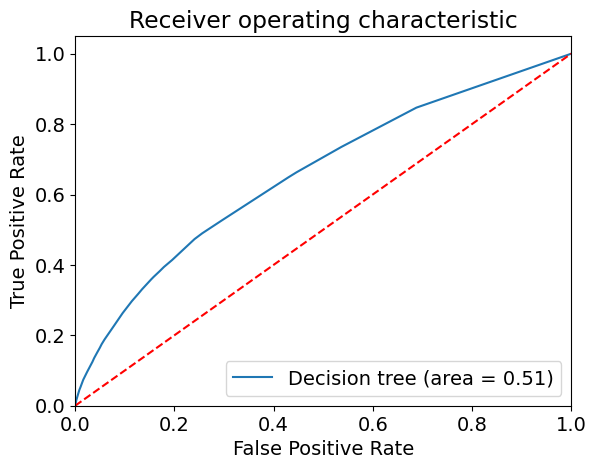

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt 
plt.rc("font", size=14)

DT_roc_auc = roc_auc_score(Y_valid, DT_model.predict(X_valid))
fpr, tpr, thresholds = roc_curve(Y_valid, DT_model.predict_proba(X_valid)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Decision tree (area = %0.2f)' % DT_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('DT_ROC')
plt.show()

### *Other models may also be helpful for this game*

Reference: https://scikit-learn.org/stable/supervised_learning.html
    

## Scoring New Data

### Prepare data for scoring

In [27]:
data3 = sas_session.sasdata2dataframe(
table='score',
libref='cortex'
)
data4 = sas_session.sasdata2dataframe(
table='score_rd2_contact',
libref='cortex'
)
data5 = sas_session.sasdata2dataframe(
table='SCORE_RD2_NOCONTACT',
libref='cortex'
)

 ### Score new data based on your champion model
 
 Pick your champion model from previous steps and use it to predict next year donations. 
 
 In this case, the Decision Tree model performed better than the Logistic Regression model based on the AUC criterion.

### Predict 'probability of giving' for members who were contacted

In [28]:
#scoring_data_contact = pd.merge(data3, data4, on=["ID"],how="right")
#scoring_data_contact.to_csv("og3_predict.csv", index= False)
scoring_data_contact = pd.read_csv("og3_predict.csv")

In [ ]:

# Perform the same strategy for handling missing values for the score dataset.
# In this case, we will only replace missing values of the MinGift variable.


var_types = {"number" : "median", "object" : "mode"}
for var_type in list(var_types.keys()):
    for col in scoring_data_contact.select_dtypes(include=var_type).columns:
        scoring_data_contact[col] = scoring_data_contact[col].fillna(getattr(scoring_data_contact[col], var_types[var_type])())

for col in scoring_data_contact.select_dtypes(include="object"):
    scoring_data_contact[col] = scoring_data_contact[col].astype('category')
    scoring_data_contact[col] = scoring_data_contact[col].cat.codes

X = scoring_data_contact[selection] 


power = PowerTransformer(method='yeo-johnson', standardize=True)
X_cols = X.columns
X = power.fit_transform(X)
X = pd.DataFrame(X, columns = X_cols) 

DT_predict_contact=logreg.predict_proba(X)[:,1]
scoring_data_contact['Prediction_prob'] = DT_predict_contact

scoring_data_contact= scoring_data_contact[['ID','Prediction_prob']]
scoring_data_contact = scoring_data_contact.rename({'Prediction_prob': 'ProbContact'}, axis=1) 
scoring_data_contact.head()

,ID,ProbContact
0,2000001.0,0.194586
1,2000002.0,0.195924
2,2000003.0,0.083573
3,2000004.0,0.097674
4,2000005.0,0.069411


### Predict 'probability of giving' for members who were not contacted

In [30]:
#scoring_data_nocontact = pd.merge(data3, data5, on=["ID"],how="right")
#scoring_data_nocontact.to_csv("og3_predict_2.csv", index= False)
scoring_data_nocontact = pd.read_csv("og3_predict_2.csv")

In [ ]:

# Perform the same strategy for handling missing values for the score dataset.
# In this case, we will only replace missing values of the MinGift variable.


var_types = {"number" : "median", "object" : "mode"}
for var_type in list(var_types.keys()):
    for col in scoring_data_nocontact.select_dtypes(include=var_type).columns:
        scoring_data_nocontact[col] = scoring_data_nocontact[col].fillna(getattr(scoring_data_nocontact[col], var_types[var_type])())

for col in scoring_data_nocontact.select_dtypes(include="object"):
    scoring_data_nocontact[col] = scoring_data_nocontact[col].astype('category')
    scoring_data_nocontact[col] = scoring_data_nocontact[col].cat.codes

X = scoring_data_nocontact[selection] 


power = PowerTransformer(method='yeo-johnson', standardize=True)
X_cols = X.columns
X = power.fit_transform(X)
X = pd.DataFrame(X, columns = X_cols) 

DT_predict_nocontact=logreg.predict_proba(X)[:,1]
scoring_data_nocontact['Prediction_prob'] = DT_predict_nocontact

scoring_data_nocontact= scoring_data_nocontact[['ID','Prediction_prob']]
scoring_data_nocontact = scoring_data_nocontact.rename({'Prediction_prob': 'ProbNoContact'}, axis=1) 
scoring_data_nocontact.head()

,ID,ProbNoContact
0,2000001.0,0.194586
1,2000002.0,0.195924
2,2000003.0,0.083573
3,2000004.0,0.097674
4,2000005.0,0.069411


In [ ]:
result_Prob = pd.merge(scoring_data_contact, scoring_data_nocontact, on=["ID"],how="right")
result_Prob.sort_values(by=['ID'], inplace=True)
result_Prob.sample(10)

,ID,ProbContact,ProbNoContact
325970,2325971.0,0.084742,0.084742
805744,2805745.0,0.155698,0.155698
438384,2438385.0,0.138283,0.138283
97753,2097754.0,0.048490,0.048490
512881,2512882.0,0.136646,0.136646
495590,2495591.0,0.353314,0.353314
715502,2715503.0,0.131196,0.131196
314944,2314945.0,0.109574,0.109574
603443,2603444.0,0.179408,0.179408
432672,2432673.0,0.066198,0.066198


## Exporting Results to a CSV File

In [ ]:
result_Prob.to_csv('Round2_Output_prob.csv', index=False)

In [ ]:
import pandas as pd

NB = 90000

probabilities = pd.read_csv("Round2_Output_prob.csv")
amounts = pd.read_csv("Round2_Output_amt.csv")

def Calc_Uplift(raw_data):
    return ((raw_data['AmtContact']*raw_data['ProbContact']) - (raw_data['AmtNoContact']*raw_data['ProbNoContact']))

raw_submission = pd.merge(probabilities, amounts, on=["ID"], how="right")
raw_submission["Uplift"] = raw_submission.apply(lambda row: Calc_Uplift(row), axis=1)

# Sorting data by descending Uplift value
raw_submission.sort_values(by=['Uplift'], ascending=False, inplace=True)


In [ ]:
# Export the final csv file

submission = raw_submission.head(NB)
submission = submission.astype({'ID':'int'})
submission["ID"].to_csv('Round2 Output final.csv', index=False)


In [ ]:
# Congratulations! You are now done with Round 2. You are ready to prepare your solution to upload it to the leaderboard.

In [ ]:
# Reminder: Please note that you need only one column (the list of donors' IDs) to submit to the leaderboard.